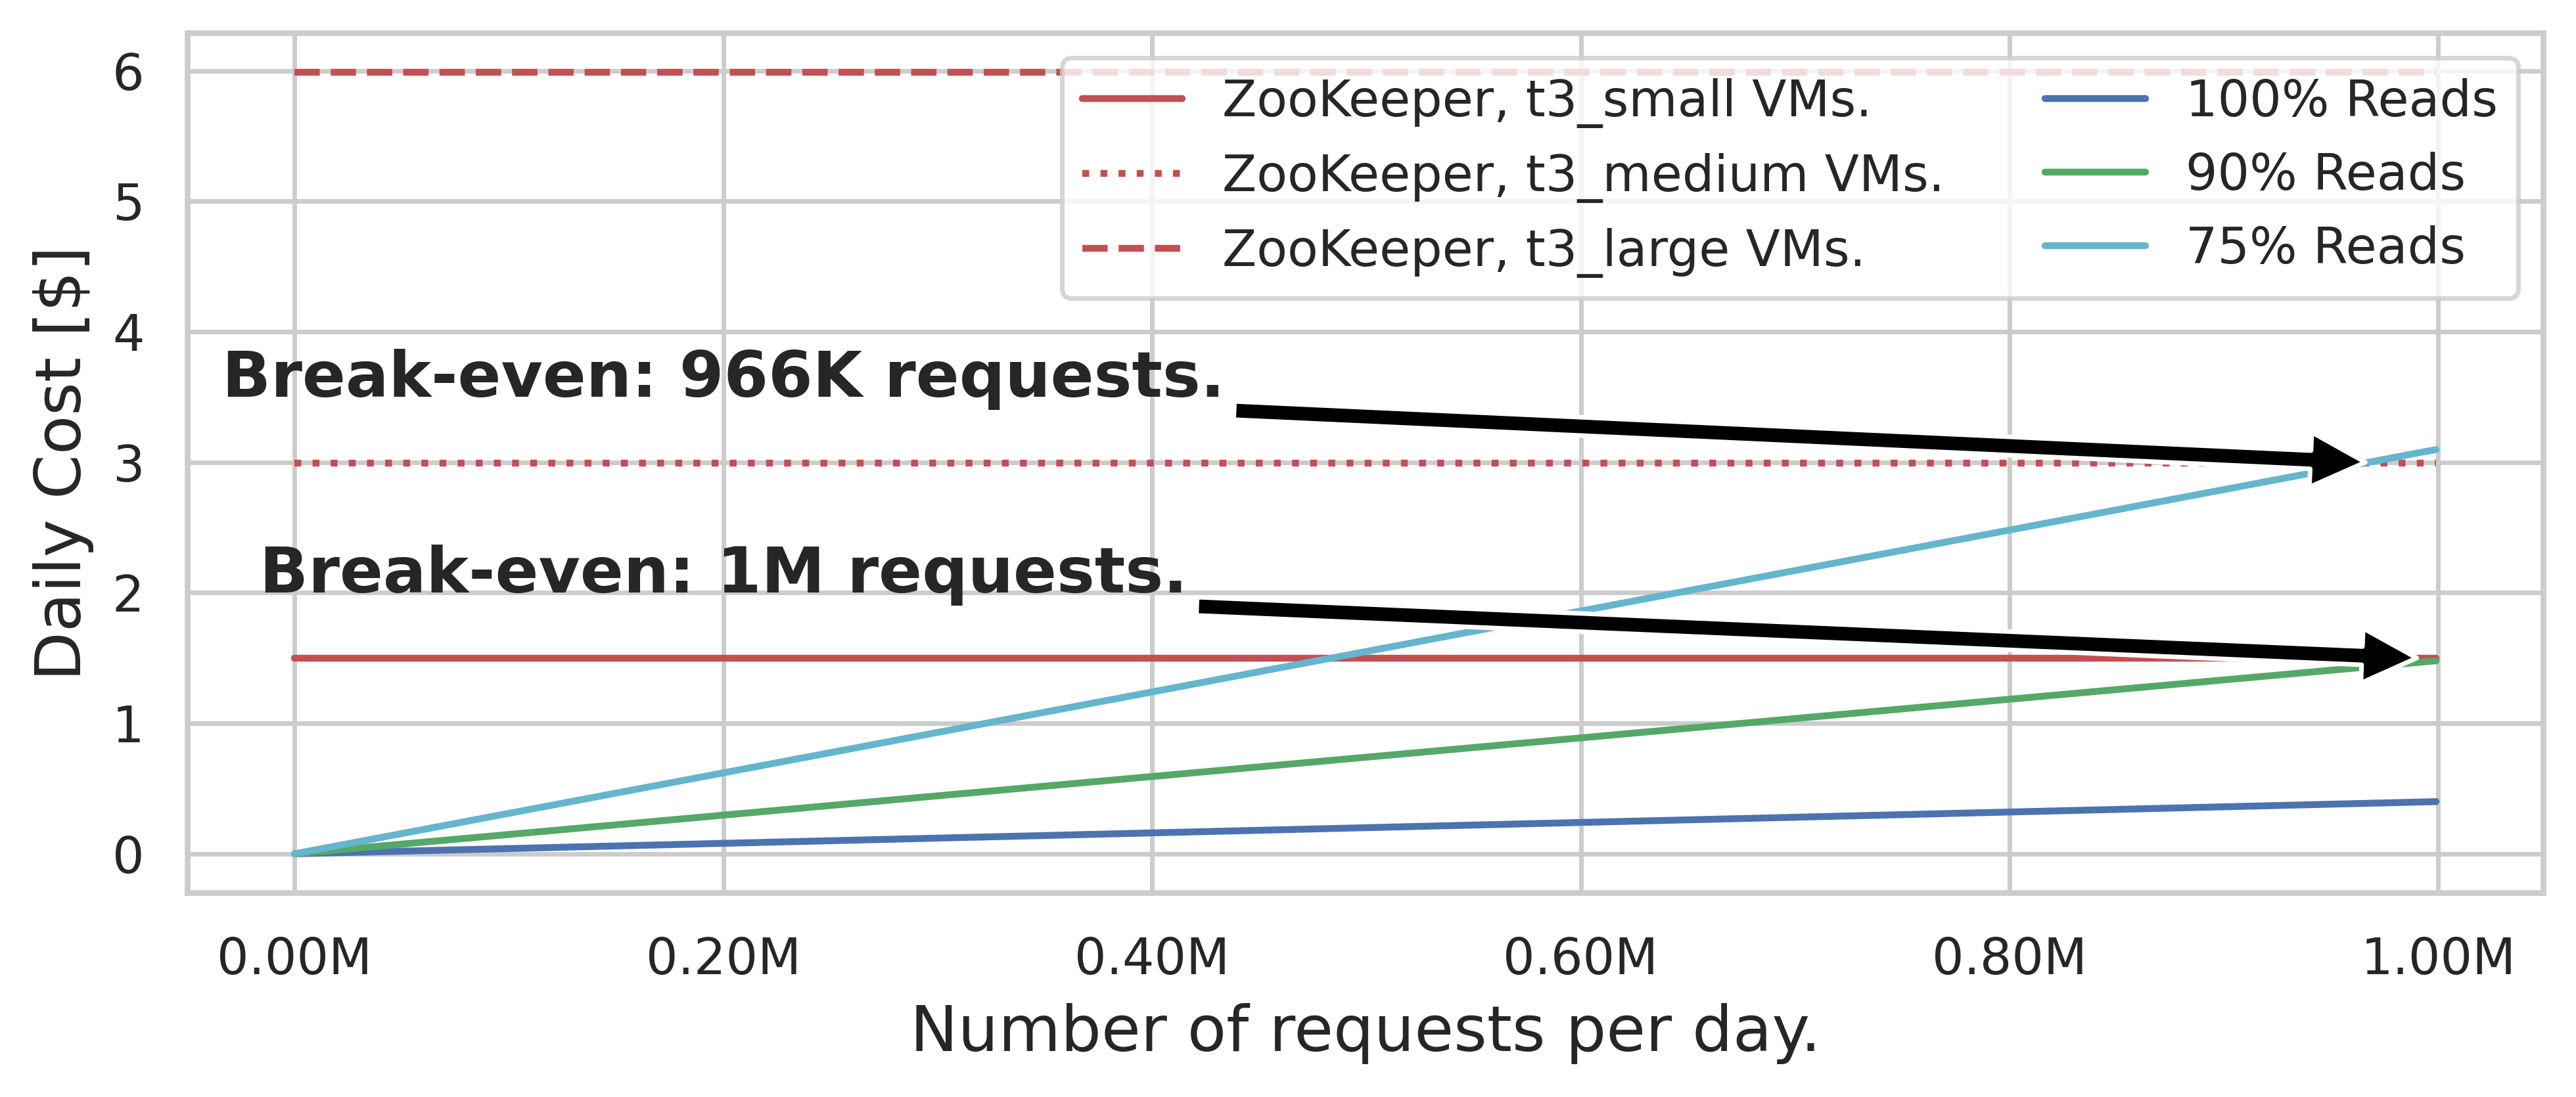

In [113]:
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.ticker as ticker

sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(8,3.5)})
sns.set_style("whitegrid")

def p50_estimator(x):                                            
    return np.percentile(x, 50)           

# EC2
# t3.small
zk_vms = 3
t3_small = zk_vms * 0.0208 * 24
t3_medium = zk_vms * 0.0416 * 24
t3_large = zk_vms * 0.0832 * 24

reqs_begin = 1
reqs_end = 10**6
reqs_step = 1000
x = list(range(reqs_begin, reqs_end, reqs_step))

for val, color, style, label, in [(t3_small, 'r', 'solid', 'ZooKeeper, t3_small VMs.'), (t3_medium, 'r', 'dotted', 'ZooKeeper, t3_medium VMs.'), (t3_large,'r', '--', 'ZooKeeper, t3_large VMs.')]:
    y = [val] * len(x)
    sns.lineplot(x=x,y=y, color = color, linestyle=style, label=label)
    
# 100% read scenario
cost = 0.4 * 10**-6
y_cost = map(lambda x : x * cost, x)
sns.lineplot(x=x,y=y_cost, color='b', label='100% Reads')

# 90% read scenario
cost = 0.4 * 10**-6
ratio = 0.9
y_cost = map(lambda x : ratio * x * cost + (1-ratio)*total_cost(512,1)*x, x)
#print(x[-1])
#print(list(y_cost)[-1])
sns.lineplot(x=x,y=y_cost, color='g', label='90% Reads')

# 75% read scenario
cost = 0.4 * 10**-6
ratio = 0.75
y_cost = map(lambda x : ratio * x * cost + (1-ratio)*total_cost(512,1)*x, x)
g = sns.lineplot(x=x,y=y_cost, color='c', label='75% Reads')

# 50% read scenario
#cost = 0.4 * 10**-6
#ratio = 0.5
#y_cost = map(lambda x : ratio * x * cost + (1-ratio)*total_cost(512,1)*x, x)
#g = sns.lineplot(x=x,y=y_cost, color='m', label='50% Reads')

#plt.grid(axis='y')
#plt.title(benchmark, fontsize=20)
#plt.xlabel('Requests submitted [op/s]',fontsize=14)
#plt.ylabel('Results received [log, op/s]', fontsize=14)

plt.xlabel('Number of requests per day.',fontsize=14)
plt.ylabel('Daily Cost [$]',fontsize=14)
#plt.xticks(x)
# plt.ylim(ymin=0)
#plt.legend(ncol=3)

#plt.xlim(10**3, 10**7)
#plt.ylim(10**-2,10**2)
#plt.yscale('log')

g.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.2f}'.format(x/1000/1000) + 'M'))

#print(plt.xticks())
#xlabels = ['{:,.2f}'.format(x/1000/1000) + 'M' for x in plt.xticks()]
#plt.xticklabels(xlabels)


g.annotate(
    'Break-even: 1M requests.',
    xy=(0.99*10**6, 1.5), xytext=(0.2*10**6, 2),
    fontsize=14, fontweight='bold', arrowprops=dict(facecolor='black', shrink=0), ha='center'
)

g.annotate(
    'Break-even: 966K requests.',
    xy=(0.966*10**6, 3), xytext=(0.2*10**6, 3.5),
    fontsize=14, fontweight='bold', arrowprops=dict(facecolor='black', shrink=0), ha='center'
)


plt.legend(ncol=2)
plt.rcParams['figure.dpi'] = 500
plt.tight_layout()

plt.savefig("cost_model.pdf",bbox_inches='tight',pad_inches = 0, transparent=False)
#plt.legend()
#plt.savefig(os.path.join(usm_data_dir, machine, "plots", f'time_{benchmark}.pdf'))

#plt.show()

In [16]:
import numpy as np
from sklearn.linear_model import LinearRegression

x = np.array([5, 15, 25, 35, 45, 55]).reshape((-1, 1))
y = np.array([5, 20, 14, 32, 22, 38])
model = LinearRegression().fit(x, y)
r_sq = model.score(x, y)
print('coefficient of determination:', r_sq)

coefficient of determination: 0.7158756137479542


In [32]:
import numpy as np
import pandas as pd
import os
from os.path import join, pardir
DATA_DIR = join(pardir, pardir, 'data', 'write_new')
DATA_DIR_ZK = join(pardir, pardir, 'data', 'write_zookeeper')

dfs = []
for mem in [512, 1024, 2048]:
    
    for size in [4, 1024, 65536, 131072, 256000]:
        df = pd.read_csv(join(DATA_DIR, f'persistent_{size}_{mem}_processed.csv'), index_col=0)
        df['size'] = size / 1024
        
        #print(df)
        # data is broken :-(
        #df = df.loc[df['memory'] == mem]
        #df = df.groupby(['memory', 'function']).head(150).reset_index(drop=True)
        #if df.shape[0] > 200:
        #    print(size, mem)
        dfs.append(df)
        
        
dynamo_df = pd.concat(dfs)
dynamo_df['system'] = 'persistent'
dynamo_df['gbs'] = dynamo_df['billed_time'] * dynamo_df['memory'] / 1024.0 / 1000
#print(dynamo_df)
#print(dynamo_df.groupby(['function', 'memory', 'size']).median()['gbs'])
#for memory in [512, 1024, 2048]

data = {}
for f in ['writer', 'distributor']:
    data[f] = {}
    for m in [512, 1024, 2048]:
        data[f][m] = []

for name, group in dynamo_df.groupby(['function', 'memory', 'size']):
    data[name[0]][name[1]].append(group['gbs'].median())
print(data)

{'writer': {512: [0.018, 0.0175, 0.049, 0.081, 0.1485], 1024: [0.035, 0.034, 0.066, 0.098, 0.171], 2048: [0.073, 0.072, 0.118, 0.176, 0.236]}, 'distributor': {512: [0.0465, 0.0475, 0.0565, 0.0645, 0.09125], 1024: [0.091, 0.09, 0.096, 0.123, 0.149], 2048: [0.162, 0.162, 0.184, 0.244, 0.298]}}


In [114]:
import numpy as np
from sklearn.linear_model import LinearRegression

x = np.array([5, 15, 25, 35, 45, 55]).reshape((-1, 1))
y = np.array([5, 20, 14, 32, 22, 38])
#model = LinearRegression().fit(x, y)
#r_sq = model.score(x, y)
#print('coefficient of determination:', r_sq)

coefficients = {}

x = np.array([0.003906, 1.000000, 64, 128, 250]).reshape((-1, 1))
for f in ['writer', 'distributor']:
    coefficients[f] = {}
    for m in [512, 1024, 2048]:
        y = data[f][m]
        model = LinearRegression().fit(x, y)
        print(f, m, model.score(x, y))
        print(f, m, model.intercept_)
        print(f, m, model.coef_)
        coefficients[f][m] = (model.coef_[0], model.intercept_)

writer 512 0.999086148804714
writer 512 0.016553228897706537
writer 512 [0.00052197]
writer 1024 0.9975164594526423
writer 1024 0.03266595875988032
writer 1024 [0.00054327]
writer 2048 0.9854924792813781
writer 2048 0.07554160822836226
writer 2048 [0.00067108]
distributor 512 0.9853993798103654
distributor 512 0.04585558054417349
distributor 512 [0.00017375]
distributor 1024 0.9682808357904945
distributor 1024 0.088351026051237
distributor 1024 [0.00024209]
distributor 2048 0.9787945761237301
distributor 2048 0.16007817783127012
distributor 2048 [0.00056345]


In [107]:
import math
# PUT, COPY, POST, LIST requests (per 1,000 requests)
def write_s3(s):
    return  5*10**-6
def write_dynamodb(s):
    return math.ceil(s) * 1.25 * 10**-6
def read_dynamodb(s):
    return math.ceil(s/4.0) * 0.25 * 10**-6
# FIFO Queues (per Million requests) 0.5
def sqs(s):
    return 0.5 * 10**-6
lambda_const = 1.66667 * 10**-5
def writer(m, s):
    return lambda_const*(coefficients['writer'][m][0] * s + coefficients['writer'][m][1]) + 0.2 * 10**-6
def distributor(m, s):
    return lambda_const*(coefficients['distributor'][m][0] * s + coefficients['distributor'][m][1]) + 0.2 * 10**-6

def total_cost(m, s):
    return 2 * sqs(s) + 3 * write_dynamodb(1) + write_s3(s) + writer(m, s) + distributor(m, s)

print(total_cost(512, 1)*9999001*0.1)
print(total_cost(512, 1)*10**6)
#print(writer(1024, 1)*10**6)
#print(distributor(1024, 1)*10**6)
print(total_cost(1024, 1)*10**6)
print(total_cost(2048, 1)*10**6)

11.200625179335683
11.201744233584618
12.180043047274175
14.097579809065936


In [121]:

ratio = 1.0
cost = ratio * 0.4 * 10**-6 + (1-ratio)*total_cost(512, 1)

print(t3_small, cost, t3_small/cost)
ratio = 0.9
cost = ratio * 0.4 * 10**-6 + (1-ratio)*total_cost(512, 1)

print(t3_small, cost, t3_small/cost)
ratio = 0.75
cost = ratio * 0.4 * 10**-6 + (1-ratio)*total_cost(512, 1)
print(t3_medium, cost, t3_medium/cost)

1.4975999999999998 4e-07 3743999.9999999995
1.4975999999999998 1.4801744233584617e-06 1011772.6508217864
2.9951999999999996 3.1004360583961545e-06 966057.65885377


In [120]:

print((write_s3(1) + 3*write_dynamodb(1))/total_cost(512, 1))
print((writer(512,1) + distributor(512,1))/total_cost(512, 1))


print((write_s3(1) + 3*write_dynamodb(1))/total_cost(2048, 1))
print((writer(2048,1) + distributor(2048,1))/total_cost(2048, 1))

0.7811283508657609
0.12959983760672356
0.6206739113030599
0.30839192740516164
